In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")


from torch.utils.data import DataLoader, TensorDataset


class NegativeBinomialLoss(nn.Module):
    def __init__(self, scale_factor=1.0, eps=1e-10):
        """
        Negative Binomial Loss
        Args:
            scale_factor (float): Scale factor applied to predictions.
            eps (float): Small value for numerical stability.
        """
        super(NegativeBinomialLoss, self).__init__()
        self.scale_factor = scale_factor
        self.eps = eps

    def forward(self, y_true, y_pred, theta):
        """
        Compute the Negative Binomial loss.
        Args:
            y_true (torch.Tensor): Ground truth counts (non-negative integers).
            y_pred (torch.Tensor): Predicted mean values (mu).
            theta (torch.Tensor): Dispersion parameter (shape parameter).
        Returns:
            torch.Tensor: Negative log-likelihood of the Negative Binomial distribution.
        """
        eps = self.eps
        y_true = y_true.float()
        y_pred = y_pred.float() * self.scale_factor
        theta = theta.float()

        # Clip theta to avoid numerical issues
        theta = torch.clamp(theta, max=1e6)

        # Negative binomial log-likelihood
        t1 = torch.lgamma(theta + eps) + torch.lgamma(y_true + 1.0) - torch.lgamma(y_true + theta + eps)
        t2 = (theta + y_true) * torch.log(1.0 + (y_pred / (theta + eps))) + \
             y_true * (torch.log(theta + eps) - torch.log(y_pred + eps))

        loss = t1 + t2
        return torch.mean(loss)  # Return mean loss over the batch


class NegativeBinomialAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim=1, dropout_rate=0.0, hidden_dim=32):
        super(NegativeBinomialAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder for mu, reconstructing only the 'y' column
        self.decoder_mu = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim), # Output dimension is now 1 for 'y'
            nn.Softplus()
        )

        # Decoder for theta, reconstructing only the 'y' column
        self.decoder_theta = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim), # Output dimension is now 1 for 'y'
            nn.Softplus()
        )

        self.nb_loss = NegativeBinomialLoss()
        self.forward_mu_only = False
        self.forward_theta_only = False
        self.latent_only = False

    def forward(self, x):
        latent = self.encoder(x)
        mu = self.decoder_mu(latent)
        theta = self.decoder_theta(latent)

        if self.forward_theta_only:
            return theta
        elif self.forward_mu_only:
            return mu
        elif self.latent_only:
            return latent
        else:
            return mu, theta

    def latent(self, x):
        return self.encoder(x)

    def compute_loss(self, x, y_true_column):
        # x is the full input, y_true_column is the specific column to reconstruct
        mu, theta = self.forward(x)
        nb_loss = self.nb_loss(y_true_column, mu, theta)
        return nb_loss


def train_autoencoder(
    model,
    data_train_full, # Full input data (including features and y)
    data_train_y,    # Only the 'y' column for reconstruction
    optimizer,
    batch_size=32,
    num_epochs=100,
):
    train_dataset = TensorDataset(data_train_full, data_train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_full, batch_y in train_loader:
            optimizer.zero_grad()
            # Pass the full input to the model's forward pass, but only batch_y to compute_loss
            loss = model.compute_loss(batch_full, batch_y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

    return model

def get_thetas(model, data_tensor_full):
    model.forward_mu_only = False
    model.forward_theta_only = True
    model.latent_only = False

    # The model still takes the full input to generate the latent representation
    lat_theta = model(data_tensor_full.cuda())

    param = pd.DataFrame(lat_theta.detach().cpu().numpy())
    mean_theta = param.mean().values
    return mean_theta

def get_mus(model, data_tensor_full):
    model.forward_mu_only = True
    model.forward_theta_only = False
    model.latent_only = False

    # The model still takes the full input to generate the latent representation
    lat_mu = model(data_tensor_full.cuda())

    param = pd.DataFrame(lat_mu.detach().cpu().numpy())
    mean_mu = param.mean().values
    return mean_mu

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")


from torch.utils.data import DataLoader, TensorDataset


class MSEAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, dropout_rate=0.0, hidden_dim=32):
        """
        MSE Autoencoder designed to predict a single output 'y' column
        from a multi-feature input, while learning a latent representation.
        Args:
            input_dim (int): Dimension of the full input data (including features and the 'y' column).
            latent_dim (int): Dimension of the latent space.
            dropout_rate (float): Dropout rate for hidden layers.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(MSEAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder for predicting the single 'y' column
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1), # Output dimension is 1 for the single 'y' prediction
        )

        self.latent_only = False # Flag to control forward pass output

    def forward(self, x):
        """
        Forward pass of the autoencoder.
        Args:
            x (torch.Tensor): Full input tensor (features + y column).
        Returns:
            torch.Tensor: Predicted 'y' values if latent_only is False,
                          else the latent representation.
        """
        latent = self.encoder(x)
        prediction = self.decoder(latent)

        if self.latent_only:
            return latent
        else:
            return prediction

    def latent(self, x):
        """
        Extracts the latent representation for a given input.
        Args:
            x (torch.Tensor): Full input tensor.
        Returns:
            torch.Tensor: Latent representation.
        """
        return self.encoder(x)


def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)
    

def train_autoencoder(
    model,
    data_train_full, # Full input data (features + y column)
    data_train_y,    # Only the 'y' column for prediction
    optimizer,
    batch_size=32,
    num_epochs=100,
    loss_fn = 'MSELoss'
):
    """
    Trains the MSE autoencoder.
    Args:
        model (nn.Module): The MSEAutoencoder instance.
        data_train_full (torch.Tensor): Tensor containing the full training input.
        data_train_y (torch.Tensor): Tensor containing the ground truth 'y' values.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        batch_size (int): Batch size for training.
        num_epochs (int): Number of training epochs.
    Returns:
        nn.Module: The trained model.
    """
    train_dataset = TensorDataset(data_train_full, data_train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Move model to device if not already done
    device = next(model.parameters()).device

    if loss_fn =='MSELoss':
        loss_fn = nn.MSELoss()
    elif loss_fn == 'LogCoshLoss':
        loss_fn = LogCoshLoss()
    else:
        loss_fn = nn.MSELoss()


    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_full, batch_y in train_loader:
            # Move batch data to the same device as the model
            batch_full = batch_full.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            predictions = model(batch_full)
            loss = loss_fn(predictions, batch_y)
           
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

    return model

def get_predictions(model, data_tensor_full):
    """
    Gets the 'y' predictions from the trained model.
    Args:
        model (nn.Module): The trained MSEAutoencoder instance.
        data_tensor_full (torch.Tensor): The full input tensor to get predictions for.
    Returns:
        torch.Tensor: Predicted 'y' values (CPU tensor).
    """
    model.latent_only = False
    model.eval() # Set model to evaluation mode

    device = next(model.parameters()).device # Get model's device
    data_tensor_full = data_tensor_full.to(device) # Move data to model's device

    with torch.no_grad(): # Disable gradient calculations
        predictions = model(data_tensor_full)

    return predictions.detach().cpu() # Return a CPU tensor

def get_latents(model, data_tensor_full):
    """
    Gets the latent representations from the trained model.
    Args:
        model (nn.Module): The trained MSEAutoencoder instance.
        data_tensor_full (torch.Tensor): The full input tensor to get latent representations for.
    Returns:
        torch.Tensor: Latent representations (CPU tensor).
    """
    model.latent_only = True
    model.eval() # Set model to evaluation mode

    device = next(model.parameters()).device # Get model's device
    data_tensor_full = data_tensor_full.to(device) # Move data to model's device

    with torch.no_grad(): # Disable gradient calculations
        latents = model(data_tensor_full)

    return latents.detach().cpu() # Return a CPU tensor


In [3]:
import scanpy as sc
## load data
adata = sc.read_h5ad('/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_easy/net_131_13677_net_67_13435_net_54_13860//data.h5ad')

## Get the data matrix from the CustumAnndata obeject
gene_names = np.array(adata.var.index)


In [4]:
import yaml
def read_config(file):
    with open(file, "r") as f:
        config = yaml.safe_load(f)
    return config

import os.path as op

#config = NetmapConfig.read_yaml("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/netmap/config/perturb_seq/")
dataset_config = read_config("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_131_13677_net_67_13435_net_54_13860.config.yaml")

nets = [pd.read_csv(op.join("/data_nfs/og86asub/netmap/netmap-evaluation/data/clustered_network/", filename), sep='\t') for filename in dataset_config['edgelist']]

netnet = pd.read_csv('/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_easy/net_131_13677_net_67_13435_net_54_13860/net.tsv', sep='\t')


In [88]:
from captum.attr import GradientShap, LRP
import cuml
import pandas as pd
import numpy as np
from tqdm import tqdm
import rapids_singlecell as rsc
from numpy import hstack

import numpy as np
from scipy.stats import nbinom
import anndata as ad
from sklearn.cluster import SpectralClustering
from statsmodels.stats.nonparametric import rank_compare_2indep

import sys
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/')
from src.evaluation.compute_metrics import unify_group_labelling
from netmap.src.utils.data_utils import attribution_to_anndata
import math


In [6]:
nets0 = nets[0]
nets1 = nets[1]

In [7]:
all_genes = list(np.unique(nets0.source)) + list(np.unique(nets0.target)) + list(np.unique(nets1.source)) + list(np.unique(nets1.target))
false_genes = np.array(list(adata.var[~adata.var.genes.isin(all_genes)].genes))

dnet = {}
dnet[1.0] = nets0
dnet[2.0] = nets1

In [ ]:

def inference_one_target(
    target_gene,
    lrp_model,
    input_data,
    background,
    xai_type='lrp-like',
    top_perc = False
   
):
    """
    Run inference for one target gene, masking its contributions multiple times.

    Args:
        target_gene: Gene to run inference for.
        lrp_model: The trained model for Layer-wise Relevance Propagation (LRP).
        data: Data, instance of CustomAnndataLoader.
        tf_gene_names: List of transcription factor gene names.
        lrp_process: Process to apply to LRP values ('abs' for absolute values).
        nt: Neural Taylor method ('lrp', 'smoothgrad', 'vargrad').
        masking_percentage: Percentage of input values to mask.
        num_iterations: Number of noisy perturbations to perform.

    Returns:
        A tuple containing:
            - Aggregated attribution values after multiple inferences with masking.
            - Names of transcription factors.
    """


    attributions_list = []
    for m in range(len(lrp_model)):
        model = lrp_model[m]
        #for _ in range(num_iterations):
        if xai_type == 'lrp-like':
            attribution = model.attribute(input_data)
                
        elif xai_type == 'shap-like':
            attribution = model.attribute(input_data, baselines = background, target = target_gene)

        attributions_list.append(attribution.detach().cpu().numpy())

    a = np.mean(attributions_list, axis = 0)
    my_att = ad.AnnData(a)
    rsc.get.anndata_to_GPU(my_att) # moves `.X` to the GPU
    rsc.pp.scale(my_att)
    rsc.pp.pca(my_att,n_comps=25 )
    rsc.pp.neighbors(my_att, n_neighbors=15)
    sc.tl.leiden(my_att, resolution=0.05)
    rsc.get.anndata_to_CPU(my_att)


    sc.tl.umap(my_att)
    sc.pl.umap(my_att, color='leiden')

    sig_dict = {}

    genelist = []
    if len(np.unique(my_att.obs['leiden']))>1 and not top_perc:
        for cat in np.unique(my_att.obs['leiden']):
            statisi =rank_compare_2indep(x1=a[my_att.obs['leiden']==cat], x2= a[my_att.obs['leiden']!=cat])
            sig_and_high = np.where((statisi.pvalue<(0.01/(input_data.shape[1]*input_data.shape[1])))  & (statisi.prob1>= 0.9))
            sig_dict[cat] = sig_and_high
            genelist = genelist+ list(sig_and_high[0])

    
    else:
        m = np.abs(a).mean(axis = 0)
        genelist = np.where(m>np.percentile(m, 90))[0]


    
    print(genelist)
    genelist = np.array(genelist).flatten()
    return my_att[:, genelist], sig_dict, genelist


gene AATF
251
Epoch 1/100, Loss: 59.4674
Epoch 11/100, Loss: 49.8776
Epoch 21/100, Loss: 49.9882
Epoch 31/100, Loss: 50.0989
Epoch 41/100, Loss: 49.9874
Epoch 51/100, Loss: 49.5750
Epoch 61/100, Loss: 50.5345
Epoch 71/100, Loss: 50.0386
Epoch 81/100, Loss: 50.1350
Epoch 91/100, Loss: 49.8224


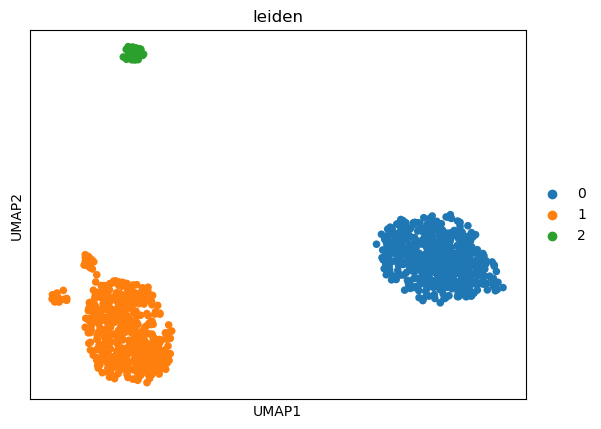

cat
69
cat
33
cat
5
[np.int64(2), np.int64(9), np.int64(11), np.int64(13), np.int64(14), np.int64(17), np.int64(19), np.int64(20), np.int64(21), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(31), np.int64(35), np.int64(40), np.int64(41), np.int64(54), np.int64(55), np.int64(57), np.int64(59), np.int64(61), np.int64(62), np.int64(65), np.int64(73), np.int64(87), np.int64(91), np.int64(98), np.int64(100), np.int64(109), np.int64(115), np.int64(124), np.int64(126), np.int64(128), np.int64(133), np.int64(141), np.int64(153), np.int64(156), np.int64(162), np.int64(167), np.int64(169), np.int64(170), np.int64(174), np.int64(178), np.int64(180), np.int64(181), np.int64(184), np.int64(186), np.int64(189), np.int64(195), np.int64(196), np.int64(197), np.int64(198), np.int64(203), np.int64(207), np.int64(209), np.int64(212), np.int64(213), np.int64(215), np.int64(219), np.int64(223), np.int64(227), np.int64(230), np.int64(231), np.int64(234), np.int64(239), np.int64(240), np.i

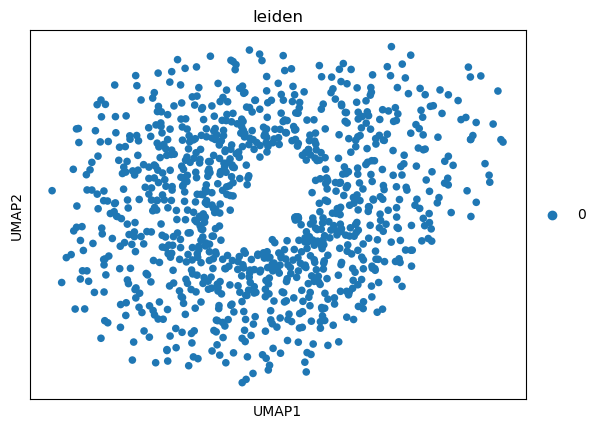

[]
Creating anndata
Setting vars


In [ ]:
def get_explainer(trained_model, lrp='GradientShap'):
    if lrp == 'GradientShap':
        explainer = GradientShap(trained_model)
        xai_type = 'shap-like'
    elif lrp == 'LRP':
        explainer = LRP(trained_model)
        xai_type = 'lrp-like'
    
    return explainer, xai_type
    


def wrapper(adata, config):

    grn_anndatas = []
    dict_list = []
    latent_dim = 10
    name_list = []
    target_names = []
    clusterings = {}

    adob = adata.obs.reset_index()
    clusterings['cell_id'] = np.array(adob['cell_id'])
    clusterings['grn'] = np.array(adob['grn'])

    for id in range(2):
        print(f'gene {gene_names[id]}')
        feature_indices_for_X = [j for j in range(adata.X.shape[1]) if j !=id ]
        #input_dim = adata.X.shape[1]-1
        feature_indices_for_X = feature_indices_for_X
        input_dim  = len(feature_indices_for_X)
        print(input_dim)
        data_train_full_tensor = torch.tensor(adata.X[:,feature_indices_for_X], dtype=torch.float32)
        data_train_y_tensor = torch.tensor(adata.X[:, id],  dtype=torch.float32)

        tms = []
        
        for i in  range(1):

            if config['model'] == 'standard':
                model = MSEAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
            elif config['model'] == 'negbin':
                model = NegativeBinomialAutoencoder(input_dim=input_dim, latent_dim=latent_dim, output_dim = 1)

            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            # Train the modelsclu.labels'lrp-like'
            trained_model = train_autoencoder(
                model,
                data_train_full_tensor,
                data_train_y_tensor,
                optimizer,
                batch_size=16,
                num_epochs=100,
                loss_fn = config['loss_fn']
            )

            trained_model.forward_mu_only = True
            explainer, xai_type = get_explainer(trained_model, config['xai_method'])
            tms.append(explainer)

        my_att, sig_dict, genelist =  inference_one_target( 
            0,
            tms,
            data_train_full_tensor,
            data_train_full_tensor,
            xai_type=xai_type,
            top_10=config['top_perc'])
        

        name_list = name_list + list(gene_names[genelist])
        target_names = target_names+[gene_names[id]]* (my_att.X.shape[1])
            

        clusterings[f'T_{gene_names[id]}'] = np.array(my_att.obs['leiden'])
        grn_anndatas.append(my_att.X)
        dict_list.append(sig_dict)


    grn_anndatas = hstack(grn_anndatas)
    index_list = [f"{s}_{t}" for (s, t) in zip(name_list, target_names)]
    cou = pd.DataFrame({'index': index_list, 'source':name_list, 'target':target_names})
    cou = cou.set_index('index')

    clusterings = pd.DataFrame(clusterings)

    grn_adata = attribution_to_anndata(grn_anndatas, var=cou, obs = clusterings)

    return grn_adata





In [ ]:
import os
import scipy.sparse as scs
import time
from netmap.src.utils.misc import write_config


def run_netmap(config, dataset_config):

    start_total = time.monotonic()
    
    ## Load config and setup outputs
    os.makedirs(config.output_directory, exist_ok=True)
    sc.settings.figdir = config.output_directory
    config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

    ## load data
    adata = sc.read_h5ad(config.input_data)
    

    ## Get the data matrix from the CustumAnndata obeject

    gene_names = np.array(adata.var.index)
    model_start = time.monotonic()

    if config.layer == 'counts':
        data_tensor = adata.layers['counts']
    else:
        data_tensor = adata.X

    if scs.issparse(data_tensor):
        data_tensor = torch.tensor(data_tensor.todense(), dtype=torch.float32)
    else:
        data_tensor = torch.tensor(data_tensor, dtype=torch.float32)


    print(data_tensor.shape)

    grn_adata = wrapper(adata, config)
    
    model_elapsed = time.monotonic()-model_start
    grn_adata.write_h5ad(op.join(config.output_directory,config.adata_filename))

    time_elapsed_total = time.monotonic()-start_total


    res = {'time_elapsed_total': time_elapsed_total, 'time_elapsed_netmap': model_elapsed} 
    write_config(res, file=op.join(config.output_directory, 'results.yaml'))

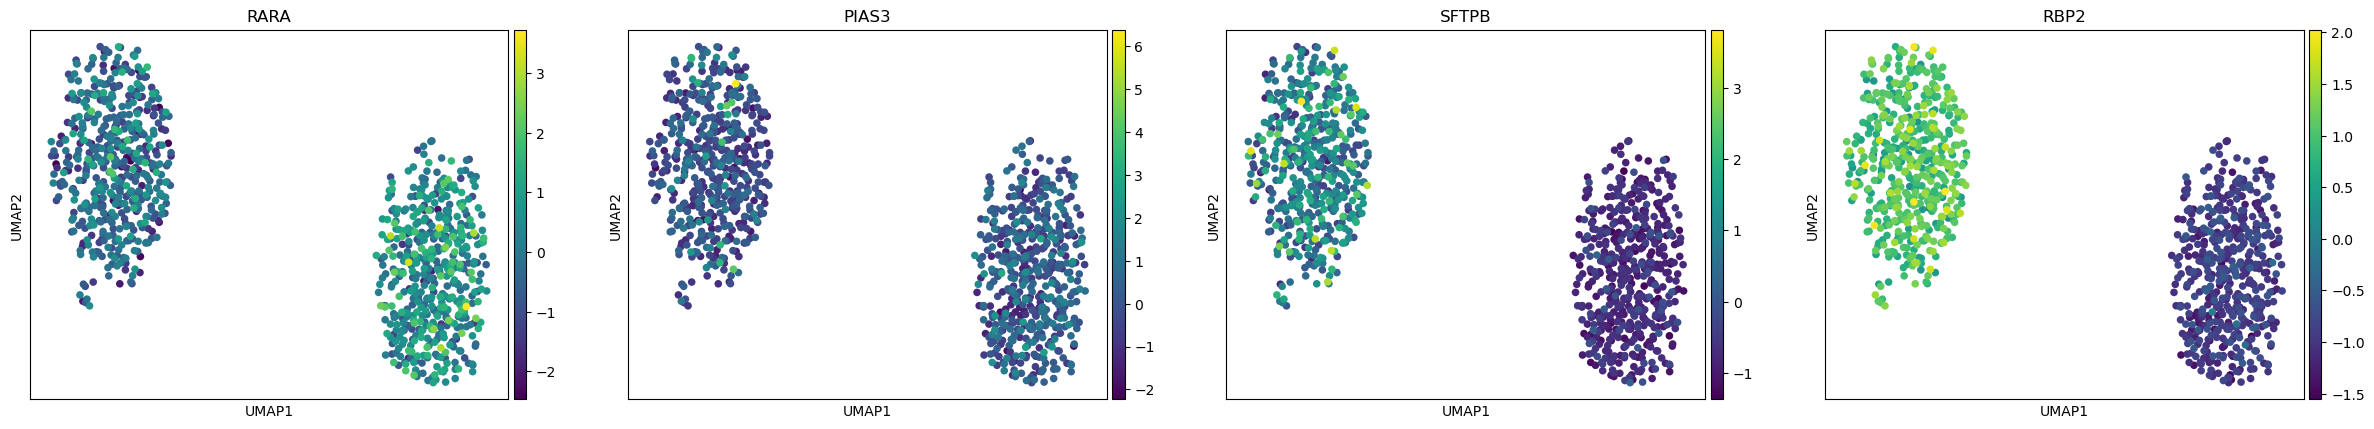

In [ ]:
sc.pl.umap(bdata, color = nets1[nets1.source == 'RXRG'].target)

In [ ]:
bdata = adata.copy()
sc.pp.scale(bdata)
sc.pp.pca(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
